# Let's try out a neural network

## Simplified Data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# from fastbook import *
# from utils import *
from fastai.tabular.all import *
from fastai.metrics import *
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# #from dtreeviz.trees import *
# from IPython.display import Image, display_svg, SVG
# from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
# from sklearn.metrics import accuracy_score, roc_auc_score 
from sklearn.metrics import roc_auc_score 


path = Path('/Users/baranserajelahi/Codes/fraud-detection-pytorch-scikit-fastai/data')
#path = Path('/home/jupyter/fraud-detection-pytorch-scikit-fastai/data')

Path.BASE_PATH = path
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 300

In [3]:
#xs_final = (path/'xs_final.pkl').load()
dep_var = 'isFraud'

In [4]:
train_ss = pd.read_csv(path/'train_ss.csv', index_col=[0], low_memory=False)

In [5]:
train_ss.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
57195,3044195,0,1316341,418.95,W,4806,490.0,150.0,visa,226.0,debit,315.0,87.0,NaN,NaN,aol.com,NaN,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,472.0,NaN,463.0,288.0,288.0,NaN,NaN,NaN,NaN,288.0,NaN,NaN,NaN,NaN,288.0,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312877,3299877,0,7780176,59.00,W,12577,268.0,150.0,visa,166.0,debit,325.0,87.0,4.0,NaN,gmail.com,NaN,5.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,4.0,0.0,NaN,NaN,330.0,196.0,NaN,NaN,NaN,NaN,400.0,301.0,NaN,NaN,NaN,330.0,T,T,T,M0,F,T,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195195,3182195,1,4394717,29.00,W,4693,417.0,150.0,visa,195.0,debit,308.0,87.0,1.0,NaN,yahoo.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,1.0,51.0,51.0,0.0,51.0,0.0,NaN,NaN,NaN,NaN,51.0,51.0,NaN,NaN,NaN,51.0,T,T,T,M0,T,F,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21600,3008600,0,572518,24.00,W,7919,194.0,150.0,mastercard,202.0,debit,123.0,87.0,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,T,M1,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12253,2999253,0,348181,57.95,W,13108,215.0,150.0,visa,226.0,debit,191.0,87.0,27.0,NaN,NaN,NaN,2.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,0.0,3.0,0.0,18.0,2.0,484.0,484.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,483.0,NaN,NaN,NaN,NaN,NaN,T,T,T,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train_ss.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9', 'id_01', 'id_02', 'id_03', 'id_04',
       'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12',
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28',
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38', 'DeviceType', 'DeviceInfo'],
      dtype='object')

In [7]:
train_ss['isFraud'] = train_ss['isFraud'].astype('category')

In [8]:
train_ss['isFraud']

57195     0
312877    0
195195    1
21600     0
12253     0
         ..
224165    0
322952    1
449491    0
343893    0
125898    0
Name: isFraud, Length: 59054, dtype: category
Categories (2, int64): [0, 1]

In [9]:
cat = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
       'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38'] 
cont = ['TransactionID', 'TransactionDT', 'TransactionAmt',
        'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 
        'C10', 'C11','C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 
        'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'id_01', 'id_02', 
        'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 
        'id_11']

In [10]:
train_ss[cat].nunique()

ProductCD           5
card1            6083
card2             499
card3              64
card4               4
card5              81
card6               4
addr1             144
addr2              27
P_emaildomain      59
R_emaildomain      59
M1                  2
M2                  2
M3                  2
M4                  3
M5                  2
M6                  2
M7                  2
M8                  2
M9                  2
DeviceType          2
DeviceInfo        766
id_12               2
id_13              37
id_14              20
id_15               3
id_16               2
id_17              60
id_18              13
id_19             358
id_20             206
id_21             131
id_22              12
id_23               3
id_24               8
id_25             126
id_26              46
id_27               1
id_28               2
id_29               2
id_30              72
id_31             107
id_32               4
id_33             112
id_34               3
id_35     

There are a number of categorical variables where the number of categories has high cardinality, so deep learning might help us in this senerio.

In [11]:
# The rows with TransactionDT <= 12579058 comprise the first 80% of the data (approximately)
cut_off = math.floor((train_ss['TransactionDT'].max() - train_ss['TransactionDT'].min())*0.8)
cut_off

12579784

In [12]:
cond = train_ss['TransactionDT'] <= cut_off
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [13]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(train_ss, procs_nn, cat, cont,
                     splits=splits, y_names=dep_var)
to_nn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [14]:
to_nn.cat_names

(#77) ['ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2','P_emaildomain'...]

In [15]:
dls = to_nn.dataloaders(1024)

In [16]:
dls.xs.columns

Index(['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'P_emaildomain',
       ...
       'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09',
       'id_10', 'id_11'],
      dtype='object', length=122)

In [18]:
F1_score = F1Score()
#Recall = Recall()
#Precision = Precision()
Roc_score = RocAucBinary()
metrics = [accuracy, F1_score, Roc_score]

In [19]:
learn = tabular_learner(dls, layers=[500,250], metrics=metrics)

In [20]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [21]:
learn.lr_find()

KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(4, 5.7e-4, wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,roc_auc_score,time
0,0.248772,0.303142,0.965437,0.026385,0.774565,00:46


SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0004786300996784121)

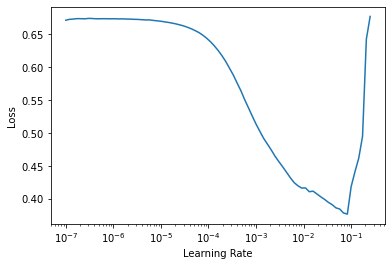

In [49]:
learn.lr_find()

In [190]:
learn.save('nn_nf_stage-1')

Path('models/nn_nf_stage-1.pth')

In [196]:
learn.load('nn_nf_stage-1')

In [197]:
learn.fit_one_cycle(4, 1e-5, wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,roc_auc_score,time
0,0.077070,0.123789,0.964500,0.280835,0.812940,00:02
1,0.076355,0.124094,0.965062,0.275728,0.810440,00:02
2,0.076460,0.124566,0.964781,0.290566,0.812533,00:02
3,0.075140,0.124526,0.964875,0.291115,0.812356,00:01


In [198]:
dls.xs.columns.shape

(122,)

## Full Data

In [222]:
train_s = pd.read_csv(path/'train_s.csv', index_col=[0], low_memory=False)
train_s['isFraud'] = train_s['isFraud'].astype('category')

In [336]:
cat = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
       'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38']
cont = ['TransactionID', 'TransactionDT', 'TransactionAmt',
        'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 
        'C10', 'C11','C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 
        'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'id_01', 'id_02', 
        'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 
        'id_11','V1', 'V2','V3','V4','V5','V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 'V240',
 'V241',
 'V242',
 'V243',
 'V244',
 'V245',
 'V246',
 'V247',
 'V248',
 'V249',
 'V250',
 'V251',
 'V252',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V258',
 'V259',
 'V260',
 'V261',
 'V262',
 'V263',
 'V264',
 'V265',
 'V266',
 'V267',
 'V268',
 'V269',
 'V270',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V276',
 'V277',
 'V278',
 'V281',
 'V282',
 'V283',
 'V288',
 'V289',
 'V296',
 'V300',
 'V301',]


In [233]:
train_ss[cat].nunique()

ProductCD           5
card1            6083
card2             499
card3              64
card4               4
card5              81
card6               4
addr1             144
addr2              27
P_emaildomain      59
R_emaildomain      59
M1                  2
M2                  2
M3                  2
M4                  3
M5                  2
M6                  2
M7                  2
M8                  2
M9                  2
DeviceType          2
DeviceInfo        766
id_12               2
id_13              37
id_14              20
id_15               3
id_16               2
id_17              60
id_18              13
id_19             358
id_20             206
id_21             131
id_22              12
id_23               3
id_24               8
id_25             126
id_26              46
id_27               1
id_28               2
id_29               2
id_30              72
id_31             107
id_32               4
id_33             112
id_34               3
id_35     

In [337]:
# The rows with TransactionDT <= 12579058 comprise the first 80% of the data (approximately)
cut_off = math.floor((train_ss['TransactionDT'].max() - train_ss['TransactionDT'].min())*0.8)
cut_off

12579784

In [338]:
cond = train_ss['TransactionDT'] <= cut_off
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [339]:
train_s = train_s.drop(['V279','V280', 'V284', 'V285', 'V286', 'V287', 'V290'
                       , 'V291', 'V292', 'V293', 'V294', 'V295', 'V297', 'V298'
                       , 'V299', 'V302', 'V303', 'V304', 'V305', 'V306',
 'V307',
 'V308',
 'V309',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V316',
 'V317',
 'V318',\
 'V319',
 'V320',
 'V321',
 'V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337','V338','V339'], axis=1)

KeyError: "['V279'] not found in axis"

In [340]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(train_s, procs_nn, cat, cont,
                     splits=splits, y_names=dep_var)
to_nn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [341]:
dls = to_nn.dataloaders(1024)

In [342]:
learn = tabular_learner(dls, layers=[500,250], metrics=metrics)
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0003981071640737355)

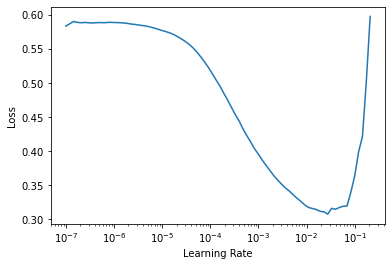

In [343]:
learn.lr_find()

In [344]:
learn.fit_one_cycle(4, 3e-4, wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,roc_auc_score,time
0,0.221122,0.462049,0.946609,0.330986,0.735843,00:08
1,0.133313,0.151749,0.967685,0.463453,0.844867,00:08
2,0.099709,0.116318,0.968340,0.453074,0.853904,00:08
3,0.081076,0.116946,0.968621,0.435076,0.851102,00:08


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.2022644114040304e-05)

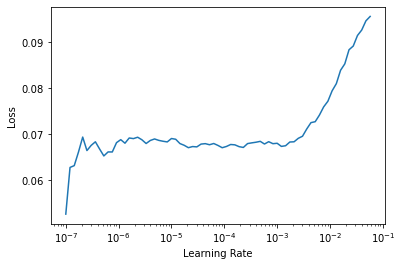

In [345]:
learn.lr_find()

In [346]:
learn.save('nn_nf_full_stage-1')

Path('models/nn_nf_full_stage-1.pth')

In [348]:
learn.load('nn_nf_full_stage-1')

In [349]:
learn.fit_one_cycle(4, 1e-4, wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,roc_auc_score,time
0,0.067690,0.119213,0.969090,0.474522,0.850427,00:07
1,0.067878,0.119424,0.967966,0.468944,0.848944,00:07
2,0.063288,0.119384,0.968715,0.474843,0.850035,00:07
3,0.059020,0.120267,0.968621,0.475743,0.850676,00:07


In [350]:
train = pd.read_csv(path/'train.csv', index_col=[0], low_memory=False)
train['isFraud'] = train['isFraud'].astype('category')

In [360]:
# The rows with TransactionDT <= 12579058 comprise the first 80% of the data (approximately)
cut_off = math.floor((train['TransactionDT'].max() - train['TransactionDT'].min())*0.8)
cut_off

12579784

In [361]:
cond = train_ss['TransactionDT'] <= cut_off
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [362]:
train = train.drop(['V279','V280', 'V284', 'V285', 'V286', 'V287', 'V290'
                       , 'V291', 'V292', 'V293', 'V294', 'V295', 'V297', 'V298'
                       , 'V299', 'V302', 'V303', 'V304', 'V305', 'V306',
 'V307',
 'V308',
 'V309',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V316',
 'V317',
 'V318',
 'V319',
 'V320',
 'V321',
 'V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337','V338','V339'], axis=1)

KeyError: "['V279' 'V280' 'V284' 'V285' 'V286' 'V287' 'V290' 'V291' 'V292' 'V293'\n 'V294' 'V295' 'V297' 'V298' 'V299' 'V302' 'V303' 'V304' 'V305' 'V306'\n 'V307' 'V308' 'V309' 'V310' 'V311' 'V312' 'V313' 'V314' 'V315' 'V316'\n 'V317' 'V318' 'V319' 'V320' 'V321' 'V322' 'V323' 'V324' 'V325' 'V326'\n 'V327' 'V328' 'V329' 'V330' 'V331' 'V332' 'V333' 'V334' 'V335' 'V336'\n 'V337' 'V338' 'V339'] not found in axis"

In [363]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(train, procs_nn, cat, cont,
                     splits=splits, y_names=dep_var)
to_nn.loss_func

KeyError: 'D1_na'

In [ ]:
dls = to_nn.dataloaders(1024)

In [ ]:
learn = tabular_learner(dls, layers=[500,250], metrics=metrics)
learn.loss_func

## Imbalanced learn

### RandomUnderSampler

In [31]:
from imblearn.under_sampling import RandomUnderSampler

In [33]:
rus = RandomUnderSampler(random_state=42)

In [47]:
df_nn, s_isFraud = rus.fit_resample(train_ss.drop(['isFraud'], axis=1), train_ss['isFraud'])

In [48]:
df_nn['isFraud'] = s_isFraud

In [50]:
df_nn

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
0,3152871,3535439,25.000,W,9152,468.0,150.0,visa,100.0,debit,337.0,87.0,37.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,64.0,64.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,64.0,64.0,NaN,NaN,NaN,64.0,T,T,T,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,3440461,11578943,57.950,W,16717,111.0,150.0,mastercard,224.0,debit,436.0,87.0,4.0,NaN,NaN,NaN,2.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,10.0,2.0,608.0,608.0,128.0,NaN,NaN,NaN,NaN,NaN,NaN,607.0,563.0,NaN,NaN,NaN,607.0,T,T,T,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3454083,12020917,36.119,C,17613,555.0,121.0,mastercard,137.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M0,NaN,NaN,NaN,NaN,NaN,-15.0,133625.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,64.0,NaN,Found,NotFound,225.0,NaN,266.0,595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,NotFound,NaN,chrome 63.0 for ios,NaN,NaN,NaN,F,F,T,F,mobile,NaN,0
3,3117399,2584737,83.950,W,1431,492.0,150.0,visa,226.0,debit,343.0,87.0,NaN,NaN,NaN,NaN,4.0,9.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,0.0,3.0,0.0,25.0,3.0,300.0,300.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,91.0,NaN,NaN,NaN,NaN,311.0,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,3307050,7950570,209.950,W,5643,543.0,150.0,mastercard,224.0,debit,231.0,87.0,1.0,NaN,gmail.com,NaN,3.0,5.0,0.0,0.0,2.0,3.0,0.0,0.0,3.0,0.0,3.0,0.0,9.0,2.0,368.0,368.0,60.0,494.0,60.0,NaN,NaN,NaN,NaN,494.0,118.0,NaN,NaN,NaN,494.0,T,T,F,NaN,NaN,T,T,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,3214687,5392241,150.000,H,11233,321.0,150.0,visa,195.0,debit,308.0,87.0,NaN,NaN,anonymous.com,gmail.com,9.0,9.0,0.0,3.0,0.0,4.0,0.0,9.0,0.0,5.0,9.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,206462.0,NaN,NaN,5.0,-9.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-360.0,New,NotFound,166.0,13.0,321.0,333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.2.1,mobile safari 11.0,32.0,2208x1242,match_status:1,T,F,F,T,mobile,iOS Device,1
4270,3460284,12238741,77.000,W,7585,553.0,150.0,visa,226.0,credit,441.0,87.0,6.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,T,T,T,M0,T,F,F,F,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4271,3382413,9934143,212.074,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,gmai

In [52]:
df_nn['isFraud'] = df_nn['isFraud'].astype('category')

In [57]:
# The rows with TransactionDT <= 12579058 comprise the first 80% of the data (approximately)
cut_off = math.floor((df_nn['TransactionDT'].max() - df_nn['TransactionDT'].min())*0.8)
cut_off

cond = df_nn['TransactionDT'] <= cut_off
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat, cont,
                     splits=splits, y_names=dep_var)
to_nn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [58]:
columns = ['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'C13', 'D3',
       'addr1', 'D2', 'C1', 'C14', 'D1', 'D15', 'C2', 'C5', 'D5', 'D4',
       'P_emaildomain', 'D10', 'card5', 'C11', 'C6', 'M4', 'dist1', 'C8',
       'D11', 'R_emaildomain', 'card6', 'M5', 'C12', 'D8', 'C9', 'id_02',
       'id_31', 'id_19', 'card4', 'M6', 'id_17', 'ProductCD', 'id_13',
       'DeviceInfo', 'C7', 'card3', 'id_01', 'D2_na', 'M9', 'M7', 'DeviceType',
       'D9', 'D3_na', 'id_06', 'addr2', 'M2', 'D5_na', 'id_33', 'id_05',
       'D4_na', 'dist2', 'dist1_na', 'D6', 'id_37', 'id_02_na', 'id_14',
       'id_18', 'D12', 'D11_na', 'D15_na']

to_nn = to_nn[columns + [dep_var]]

assert len(to_nn.columns)==(len(columns)+1)

In [62]:
to_nn.shape

(4274, 67)

In [61]:
dls = to_nn.dataloaders(1024)

AttributeError: 'DataFrame' object has no attribute 'dataloaders'

In [60]:
learn = tabular_learner(dls, layers=[500,250], metrics=metrics)
learn.loss_func

AttributeError: 'DataFrame' object has no attribute 'dataloaders'

### RandomOverSampler

In [83]:
from imblearn.over_sampling import RandomOverSampler

In [84]:
ros = RandomOverSampler(random_state=42)

In [85]:
df_nn, s_isFraud = ros.fit_resample(train_ss.drop(['isFraud'], axis=1), train_ss['isFraud'])

In [86]:
df_nn['isFraud'] = s_isFraud

In [87]:
df_nn

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
0,3044195,1316341,418.950,W,4806,490.0,150.0,visa,226.0,debit,315.0,87.0,NaN,NaN,aol.com,NaN,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,472.0,NaN,463.0,288.0,288.0,NaN,NaN,NaN,NaN,288.0,NaN,NaN,NaN,NaN,288.0,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,3299877,7780176,59.000,W,12577,268.0,150.0,visa,166.0,debit,325.0,87.0,4.0,NaN,gmail.com,NaN,5.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,4.0,0.0,NaN,NaN,330.0,196.0,NaN,NaN,NaN,NaN,400.0,301.0,NaN,NaN,NaN,330.0,T,T,T,M0,F,T,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3182195,4394717,29.000,W,4693,417.0,150.0,visa,195.0,debit,308.0,87.0,1.0,NaN,yahoo.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,1.0,51.0,51.0,0.0,51.0,0.0,NaN,NaN,NaN,NaN,51.0,51.0,NaN,NaN,NaN,51.0,T,T,T,M0,T,F,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,3008600,572518,24.000,W,7919,194.0,150.0,mastercard,202.0,debit,123.0,87.0,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,T,M1,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2999253,348181,57.950,W,13108,215.0,150.0,visa,226.0,debit,191.0,87.0,27.0,NaN,NaN,NaN,2.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,0.0,3.0,0.0,18.0,2.0,484.0,484.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,483.0,NaN,NaN,NaN,NaN,NaN,T,T,T,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113829,3118835,2609959,72.568,C,9633,296.0,185.0,visa,138.0,debit,NaN,NaN,NaN,1.0,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,20.166666,0.166666,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M0,NaN,NaN,NaN,NaN,NaN,-5.0,400746.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,225.0,NaN,153.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 63.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows,1
113830,3058702,1613132,100.000,S,11331,399.0,150.0,american express,146.0,credit,330.0,87.0,NaN,NaN,NaN,gmail.com,2.0,3.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,5.0,1.0,0.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,0.666666,0.666666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,87781.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,New,NotFound,166.0,NaN,214.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Linux,chrome 63.0,32.0,NaN,match_status:2,T,F,T,T,desktop,NaN,1
113831,3267133,6818616,235.638,C,6480,555.0,144.0,mastercard,137.0,credit,NaN,NaN,NaN,2421.0,gmail.com,gmail.com,2.0,2.0,0.0,1.0,0.0

In [88]:
df_nn['isFraud'] = df_nn['isFraud'].astype('category')

In [89]:
# The rows with TransactionDT <= 12579058 comprise the first 80% of the data (approximately)
cut_off = math.floor((df_nn['TransactionDT'].max() - df_nn['TransactionDT'].min())*0.8)
cut_off

cond = df_nn['TransactionDT'] <= cut_off
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat, cont,
                     splits=splits, y_names=dep_var)
to_nn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [90]:
columns = ['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'C13', 'D3',
       'addr1', 'D2', 'C1', 'C14', 'D1', 'D15', 'C2', 'C5', 'D5', 'D4',
       'P_emaildomain', 'D10', 'card5', 'C11', 'C6', 'M4', 'dist1', 'C8',
       'D11', 'R_emaildomain', 'card6', 'M5', 'C12', 'D8', 'C9', 'id_02',
       'id_31', 'id_19', 'card4', 'M6', 'id_17', 'ProductCD', 'id_13',
       'DeviceInfo', 'C7', 'card3', 'id_01', 'D2_na', 'M9', 'M7', 'DeviceType',
       'D9', 'D3_na', 'id_06', 'addr2', 'M2', 'D5_na', 'id_33', 'id_05',
       'D4_na', 'dist2', 'dist1_na', 'D6', 'id_37', 'id_02_na', 'id_14',
       'id_18', 'D12', 'D11_na', 'D15_na']

to_nn = to_nn[columns + [dep_var]]

assert len(to_nn.columns)==(len(columns)+1)

In [91]:
to_nn.shape

(113834, 67)

In [92]:
dls = to_nn.dataloaders(1024)

AttributeError: 'DataFrame' object has no attribute 'dataloaders'

In [93]:
learn = tabular_learner(dls, layers=[500,250], metrics=metrics)
learn.loss_func

NameError: name 'dls' is not defined